In [1]:
import pandas as pd, numpy as np, os
import matplotlib.pyplot as plt
import gc
from tqdm import tqdm
from tensorflow.keras import layers, models, optimizers, losses, activations
from keras.callbacks import ModelCheckpoint
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.naive_bayes import GaussianNB, MultinomialNB
from sklearn.ensemble import StackingClassifier, VotingClassifier
from tensorflow.keras.utils import plot_model, to_categorical
from sklearn.metrics import RocCurveDisplay
from sklearn.model_selection import StratifiedKFold
from scipy.signal import butter, lfilter
import tensorflow as tf
from keras.saving import load_model

from sklearn.model_selection import KFold, GroupKFold
import tensorflow.keras.backend as K, gc

2024-02-05 12:45:06.053411: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-02-05 12:45:06.053536: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-02-05 12:45:06.183962: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


Using [@cdeotte's](https://www.kaggle.com/cdeotte) data generation

In [2]:
import pandas as pd, numpy as np, os
import matplotlib.pyplot as plt

train = pd.read_csv('/kaggle/input/hms-harmful-brain-activity-classification/train.csv')
print( train.shape )
display( train.head() )

# CHOICE TO CREATE OR LOAD EEGS FROM NOTEBOOK VERSION 1
CREATE_EEGS = False
TRAIN_MODEL = True

(106800, 15)


,eeg_id,eeg_sub_id,eeg_label_offset_seconds,spectrogram_id,spectrogram_sub_id,spectrogram_label_offset_seconds,label_id,patient_id,expert_consensus,seizure_vote,lpd_vote,gpd_vote,lrda_vote,grda_vote,other_vote
0,1628180742,0,0.0,353733,0,0.0,127492639,42516,Seizure,3,0,0,0,0,0
1,1628180742,1,6.0,353733,1,6.0,3887563113,42516,Seizure,3,0,0,0,0,0
2,1628180742,2,8.0,353733,2,8.0,1142670488,42516,Seizure,3,0,0,0,0,0
3,1628180742,3,18.0,353733,3,18.0,2718991173,42516,Seizure,3,0,0,0,0,0
4,1628180742,4,24.0,353733,4,24.0,3080632009,42516,Seizure,3,0,0,0,0,0


In [3]:
df = pd.read_parquet('/kaggle/input/hms-harmful-brain-activity-classification/train_eegs/1000913311.parquet')
FEATS = df.columns
print(f'There are {len(FEATS)} raw eeg features')
print( list(FEATS) )

There are 20 raw eeg features
['Fp1', 'F3', 'C3', 'P3', 'F7', 'T3', 'T5', 'O1', 'Fz', 'Cz', 'Pz', 'Fp2', 'F4', 'C4', 'P4', 'F8', 'T4', 'T6', 'O2', 'EKG']


In [4]:
print('We will use the following subset of raw EEG features:')
FEATS = ['Fp1','T3','C3','O1','Fp2','C4','T4','O2']
FEAT2IDX = {x:y for x,y in zip(FEATS,range(len(FEATS)))}
print( list(FEATS) )

We will use the following subset of raw EEG features:
['Fp1', 'T3', 'C3', 'O1', 'Fp2', 'C4', 'T4', 'O2']


In [5]:
def eeg_from_parquet(parquet_path, display=False):

    # EXTRACT MIDDLE 50 SECONDS
    eeg = pd.read_parquet(parquet_path, columns=FEATS)
    rows = len(eeg)
    offset = (rows-10_000)//2
    eeg = eeg.iloc[offset:offset+10_000]

    if display:
        plt.figure(figsize=(10,5))
        offset = 0

    # CONVERT TO NUMPY
    data = np.zeros((10_000,len(FEATS)))
    for j,col in enumerate(FEATS):

        # FILL NAN
        x = eeg[col].values.astype('float32')
        m = np.nanmean(x)
        if np.isnan(x).mean()<1: x = np.nan_to_num(x,nan=m)
        else: x[:] = 0

        data[:,j] = x

        if display:
            if j!=0: offset += x.max()
            plt.plot(range(10_000),x-offset,label=col)
            offset -= x.min()

    if display:
        plt.legend()
        name = parquet_path.split('/')[-1]
        name = name.split('.')[0]
        plt.title(f'EEG {name}',size=16)
        plt.show()

    return data



In [6]:
%%time

all_eegs = np.load('/kaggle/input/brain-eegs/eegs.npy',allow_pickle=True).item()

CPU times: user 5.1 s, sys: 9.15 s, total: 14.2 s
Wall time: 1min 33s


In [7]:
# LOAD TRAIN
EEG_IDS = train.eeg_id.unique()
df = pd.read_csv('/kaggle/input/hms-harmful-brain-activity-classification/train.csv')
TARGETS = df.columns[-6:]
TARS = {'Seizure':0, 'LPD':1, 'GPD':2, 'LRDA':3, 'GRDA':4, 'Other':5}
TARS2 = {x:y for y,x in TARS.items()}

train = df.groupby('eeg_id')[['patient_id']].agg('first')

tmp = df.groupby('eeg_id')[TARGETS].agg('sum')
for t in TARGETS:
    train[t] = tmp[t].values

y_data = train[TARGETS].values
y_data = y_data / y_data.sum(axis=1,keepdims=True)
train[TARGETS] = y_data

tmp = df.groupby('eeg_id')[['expert_consensus']].agg('first')
train['target'] = tmp

train = train.reset_index()
train = train.loc[train.eeg_id.isin(EEG_IDS)]
print('Train Data with unique eeg_id shape:', train.shape )
train.head()

Train Data with unique eeg_id shape: (17089, 9)


,eeg_id,patient_id,seizure_vote,lpd_vote,gpd_vote,lrda_vote,grda_vote,other_vote,target
0,568657,20654,0.0,0.000000,0.25,0.000000,0.166667,0.583333,Other
1,582999,20230,0.0,0.857143,0.00,0.071429,0.000000,0.071429,LPD
2,642382,5955,0.0,0.000000,0.00,0.000000,0.000000,1.000000,Other
3,751790,38549,0.0,0.000000,1.00,0.000000,0.000000,0.000000,GPD
4,778705,40955,0.0,0.000000,0.00,0.000000,0.000000,1.000000,Other


In [8]:
from scipy.signal import butter, lfilter
def butter_lowpass_filter(data, cutoff_freq=20, sampling_rate=200, order=7): 
    nyquist = 0.5 * sampling_rate
    normal_cutoff = cutoff_freq / nyquist
    b, a = butter(order, normal_cutoff, btype='low', analog=False)
    filtered_data = lfilter(b, a, data, axis=0)
    return filtered_data

In [9]:
class DataGenerator(tf.keras.utils.Sequence):
    'Generates data for Keras'
    def __init__(self, data, batch_size=32, shuffle=False, eegs=all_eegs, mode='train',
                 downsample=5):

        self.data = data
        self.batch_size = batch_size
        self.shuffle = shuffle
        self.eegs = eegs
        self.mode = mode
        self.downsample = downsample
        self.on_epoch_end()

    def __len__(self):
        'Denotes the number of batches per epoch'
        ct = int( np.ceil( len(self.data) / self.batch_size ) )
        return ct

    def __getitem__(self, index):
        'Generate one batch of data'
        indexes = self.indexes[index*self.batch_size:(index+1)*self.batch_size]
        X, y = self.__data_generation(indexes)

        return X[:,::self.downsample,:], y
        #return decimate(X, self.downsample, axis=1), y

    def on_epoch_end(self):
        'Updates indexes after each epoch'
        self.indexes = np.arange( len(self.data) )
        if self.shuffle: np.random.shuffle(self.indexes)

    def __data_generation(self, indexes):
        'Generates data containing batch_size samples'

        X = np.zeros((len(indexes),10_000,8),dtype='float32')
        y = np.zeros((len(indexes),6),dtype='float32')

        sample = np.zeros((10_000,X.shape[-1]))
        for j,i in enumerate(indexes):
            row = self.data.iloc[i]
            data = self.eegs[row.eeg_id]

            # FEATURE ENGINEER
            sample[:,0] = data[:,FEAT2IDX['Fp1']] - data[:,FEAT2IDX['T3']]
            sample[:,1] = data[:,FEAT2IDX['T3']] - data[:,FEAT2IDX['O1']]

            sample[:,2] = data[:,FEAT2IDX['Fp1']] - data[:,FEAT2IDX['C3']]
            sample[:,3] = data[:,FEAT2IDX['C3']] - data[:,FEAT2IDX['O1']]


            sample[:,4] = data[:,FEAT2IDX['Fp2']] - data[:,FEAT2IDX['C4']]
            sample[:,5] = data[:,FEAT2IDX['C4']] - data[:,FEAT2IDX['O2']]

            sample[:,6] = data[:,FEAT2IDX['Fp2']] - data[:,FEAT2IDX['T4']]
            sample[:,7] = data[:,FEAT2IDX['T4']] - data[:,FEAT2IDX['O2']]



            # STANDARDIZE
            sample = np.clip(sample,-1024,1024)
            sample = np.nan_to_num(sample, nan=0) / 32.0

            # BUTTER LOW-PASS FILTER
            sample = butter_lowpass_filter(sample)

            X[j,] = sample
            if self.mode!='test':
                y[j] = row[TARGETS]
        return X,y

In [10]:
# USE MIXED PRECISION
MIX = True
if MIX:
    tf.config.optimizer.set_experimental_options({"auto_mixed_precision": True})
    print('Mixed precision enabled')
else:
    print('Using full precision')

Mixed precision enabled


Implementation of ChronoNet architecture

Making ChronoNet with input (2000, 8) and 6 classes
Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 2000, 8)]            0         []                            
                                                                                                  
 conv1d (Conv1D)             (None, 1000, 128)            2176      ['input_1[0][0]']             
                                                                                                  
 conv1d_1 (Conv1D)           (None, 1000, 128)            4224      ['input_1[0][0]']             
                                                                                                  
 conv1d_2 (Conv1D)           (None, 1000, 128)            8320      ['input_1[0][0]']             
                                          

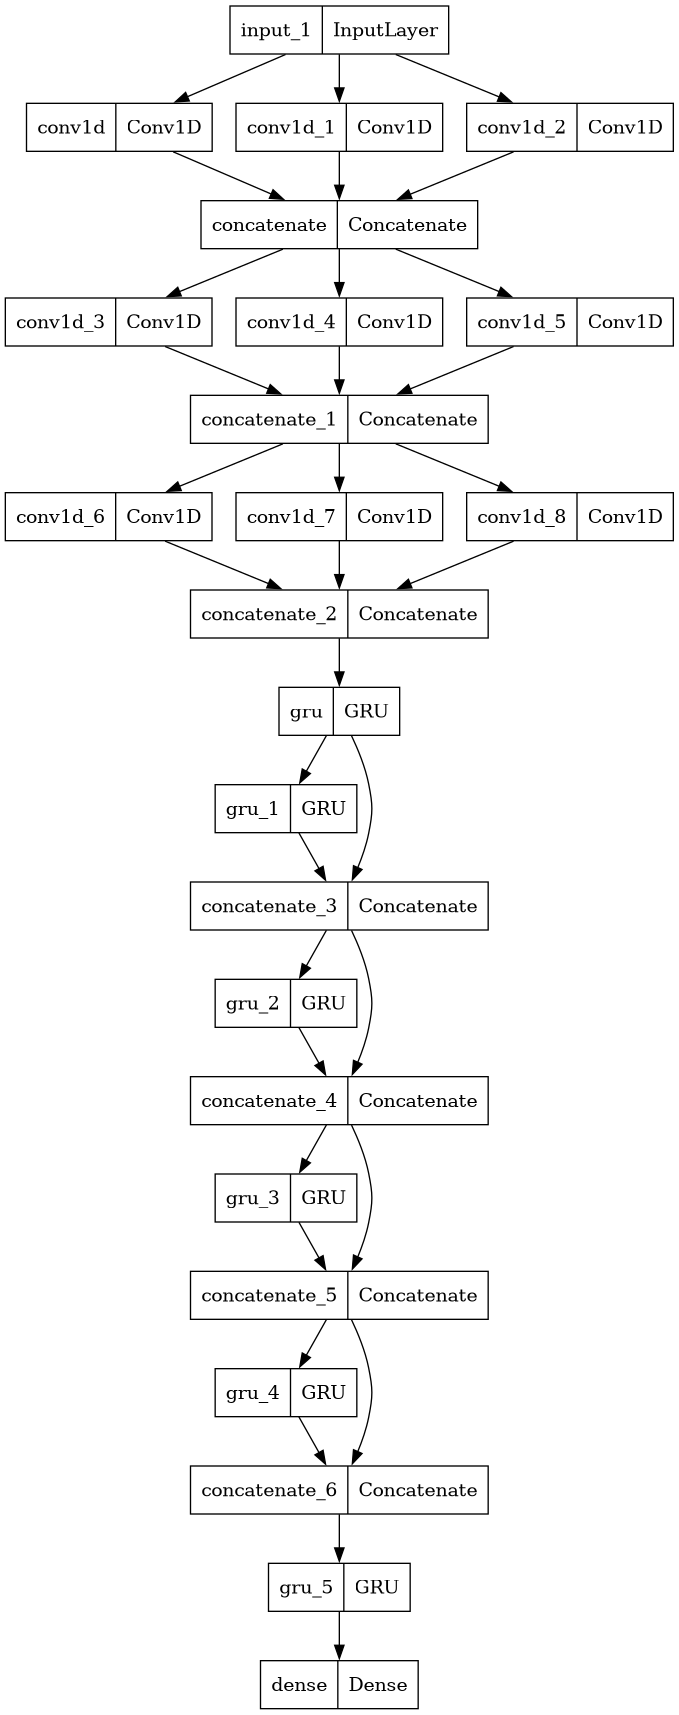

In [11]:
def chronoNet(input_shape=(2000,8), num_classes=6):
    print(f'Making ChronoNet with input {input_shape} and {num_classes} classes')
    inp = layers.Input(shape=input_shape)
    
    # Inception Style Convolutional layers
    cat = inp
    for i in range(3):
        conv1 = layers.Conv1D(128, 2, strides=2, padding='same')(cat)
        conv2 = layers.Conv1D(128, 4, strides=2, padding='same')(cat)
        conv3 = layers.Conv1D(128, 8, strides=2, padding='same')(cat)
        cat = layers.concatenate([conv1, conv2, conv3])
    
    # DenseNet style RNN layers
    rnn1 = layers.GRU(128, return_sequences=True)(cat)
    rnn2 = layers.GRU(128, return_sequences=True)(rnn1)
    cat = layers.concatenate([rnn1, rnn2])
    for i in range(3):
        rnn = layers.GRU(128, return_sequences=True)(cat)
        cat = layers.concatenate([cat, rnn])

    rnn = layers.GRU(128)(cat)

    x = layers.Dense(6, activation='softmax', dtype='float32')(rnn)

    # COMPILE MODEL
    model = tf.keras.Model(inputs=inp, outputs=x)
    loss = tf.keras.losses.KLDivergence()
    opt = tf.keras.optimizers.AdamW(learning_rate = 1e-3, clipvalue=50.0)
    model.compile(loss=loss, 
                  optimizer = opt, 
                  metrics=['accuracy', tf.keras.metrics.AUC()],)
    return model
    
model = chronoNet()
model.summary()
plot_model(model)

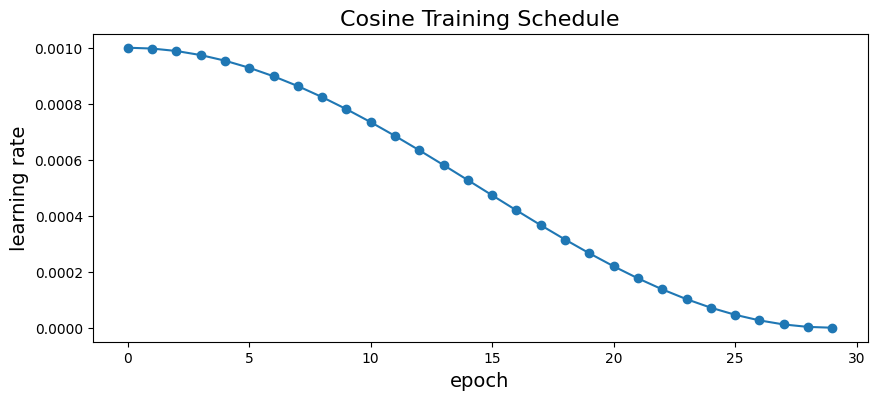

In [12]:
import math
LR_START = 1e-6
LR_MAX = 1e-3
LR_MIN = 1e-6
LR_RAMPUP_EPOCHS = 0
LR_SUSTAIN_EPOCHS = 0
EPOCHS2 = 30

def lrfn(epoch):
    if epoch < LR_RAMPUP_EPOCHS:
        lr = (LR_MAX - LR_START) / LR_RAMPUP_EPOCHS * epoch + LR_START
    elif epoch < LR_RAMPUP_EPOCHS + LR_SUSTAIN_EPOCHS:
        lr = LR_MAX
    else:
        decay_total_epochs = EPOCHS2 - LR_RAMPUP_EPOCHS - LR_SUSTAIN_EPOCHS - 1
        decay_epoch_index = epoch - LR_RAMPUP_EPOCHS - LR_SUSTAIN_EPOCHS
        phase = math.pi * decay_epoch_index / decay_total_epochs
        cosine_decay = 0.5 * (1 + math.cos(phase))
        lr = (LR_MAX - LR_MIN) * cosine_decay + LR_MIN
    return lr

rng = [i for i in range(EPOCHS2)]
lr_y = [lrfn(x) for x in rng]
plt.figure(figsize=(10, 4))
plt.plot(rng, lr_y, '-o')
plt.xlabel('epoch',size=14); plt.ylabel('learning rate',size=14)
plt.title('Cosine Training Schedule',size=16); plt.show()

LR2 = tf.keras.callbacks.LearningRateScheduler(lrfn, verbose = True)

In [ ]:
gkf = GroupKFold(n_splits=5)
for i, (train_index, valid_index) in enumerate(gkf.split(train, train.target, train.patient_id)):

    print('#'*25)
    print(f'### Fold {i+1}')
    mix_gen = DataGenerator(train.iloc[train_index], shuffle=True, batch_size=32)
    train_gen = DataGenerator(train.iloc[train_index], shuffle=True, batch_size=32)
    valid_gen = DataGenerator(train.iloc[valid_index], shuffle=False, batch_size=64, mode='valid')
    print(f'### train size {len(train_index)}, valid size {len(valid_index)}')
    print('#'*25)

    # TRAIN MODEL
    model = chronoNet()
    checkpoint_callback = ModelCheckpoint(
            f'best_1D-Chrono_f{i}.h5',
            monitor='val_loss',  # Choose the metric to monitor for saving the best model
            save_best_only=True,  # Save only the best model
            mode='min',  # 'min' if monitoring loss, 'max' if monitoring accuracy
            verbose=1  # Display messages about the saving process
    )

    model.fit(train_gen, verbose=1,
              validation_data = valid_gen,
              epochs=30,
              callbacks=[checkpoint_callback],
                  )

#########################
### Fold 1
### train size 13671, valid size 3418
#########################
Making ChronoNet with input (2000, 8) and 6 classes
Epoch 1/30


I0000 00:00:1707137229.065776     119 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


428/428 [==============================] - ETA: 0s - loss: 1.2806 - accuracy: 0.4064 - auc_1: 0.6708
Epoch 1: val_loss improved from inf to 1.25127, saving model to best_1D-Chrono_f0.h5
428/428 [==============================] - 77s 144ms/step - loss: 1.2806 - accuracy: 0.4064 - auc_1: 0.6708 - val_loss: 1.2513 - val_accuracy: 0.4102 - val_auc_1: 0.6636
Epoch 2/30


/opt/conda/lib/python3.10/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


428/428 [==============================] - ETA: 0s - loss: 1.1961 - accuracy: 0.4384 - auc_1: 0.6970
Epoch 2: val_loss did not improve from 1.25127
428/428 [==============================] - 59s 137ms/step - loss: 1.1961 - accuracy: 0.4384 - auc_1: 0.6970 - val_loss: 1.2561 - val_accuracy: 0.4207 - val_auc_1: 0.6541
Epoch 3/30
428/428 [==============================] - ETA: 0s - loss: 1.1876 - accuracy: 0.4437 - auc_1: 0.7013
Epoch 3: val_loss improved from 1.25127 to 1.25078, saving model to best_1D-Chrono_f0.h5
428/428 [==============================] - 58s 136ms/step - loss: 1.1876 - accuracy: 0.4437 - auc_1: 0.7013 - val_loss: 1.2508 - val_accuracy: 0.4254 - val_auc_1: 0.6656
Epoch 4/30
428/428 [==============================] - ETA: 0s - loss: 1.1881 - accuracy: 0.4418 - auc_1: 0.7012
Epoch 4: val_loss did not improve from 1.25078
428/428 [==============================] - 58s 135ms/step - loss: 1.1881 - accuracy: 0.4418 - auc_1: 0.7012 - val_loss: 1.2578 - val_accuracy: 0.4154 - 